# PRÁCTICA 4 : ANÁLISIS DE DATOS PARALELO CON BICIMAD


 - **David Parro Plaza**
 - **Francisco Javier Abollado**
 - **Juan Alvarez San Romualdo**


## Tema elegido 

Nuestro objetivo es trabajar con los datos de biciMad para estudiar la demanda de este servicio y lo realizaremos intentando  obtener los siguientes resultados.

* Cuántas salidas y entradas de bicicletas hay por barrios.
* Cómo afecta el día de la semana al uso de biciMad. 
* Salidas menos entradas para ver el uso porcentual por barrio.
* La máxima demanda de bicicletas en un barrio.
* Las conexiones mas usuales entre las distintas estaciones
* El crecimiento de la demanda del servicio a lo largo del tiempo.


además estudiaremos su optimización en la distribución de las bicicletas y veremos cuales serían las paradas que debería hacer un hipotético camión reponedor de la compañía para aumentar la eficiencia.

In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as sf
from pyspark.sql.types import StringType

from main import *



data_path = "datos/sample_10e4.json"

spark = SparkSession.builder.getOrCreate()

df = spark.read.json(data_path)
df_geo = spark.read.csv("datos/bases_bicimad.csv", header=True)

df_new = preprocess(df, df_geo)

In [2]:
df_geo3   = df_geo.withColumnRenamed('Número', 'plug_station')
df_geo3   = df_geo3.withColumn('plug_station', sf.col('plug_station').cast(StringType()))
df        = spark.read.json(data_path)
df        = df.withColumn('idplug_station', sf.col('idplug_station').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(2, 10))

In [3]:
df.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004


Vamos a centrar nuestro análisis en los barrios, para ello primero analizaremos un caso concreto

el de **Inserta barrio**

In [4]:
df_barrios = df_geo3.select('plug_station', 'Barrio')
df_barrios.printSchema()

root
 |-- plug_station: string (nullable = true)
 |-- Barrio: string (nullable = true)



In [5]:
df_unido_llegadas = df.join(df_barrios, df_barrios.plug_station ==  df.idplug_station,"left")
df_unido_llegadas = df_unido_llegadas.withColumnRenamed('Barrio', 'Barrio_L')

df_unido_salidas  = df.join(df_barrios, df_barrios.plug_station ==  df.idunplug_station,"left")
df_unido_salidas  = df_unido_salidas.withColumnRenamed('Barrio', 'Barrio_S')

In [6]:
df_unido_llegadas.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_L
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,58,01-04 JUSTICIA
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,90,04-01 RECOLETOS
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045,172,02-06 PALOS DE MOGUER
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005,109,04-06 CASTELLANA
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004,101,04-02 GOYA


In [7]:
salidas     = ['idunplug_station', 'unplug_hourTime', 'Barrio_S']
df_salidas  = df_unido_salidas.select(*salidas).groupBy('Barrio_S').count()
df_salidas = df_salidas.withColumnRenamed('count', 'salidas')

llegadas    = ['idplug_station', 'Barrio_L']
df_llegadas = df_unido_llegadas.select(*llegadas).groupBy('Barrio_L').count()
df_llegadas = df_llegadas.withColumnRenamed('count', 'llegadas')

Ahora que tenemos agrupados los datos en una cantidad pequeña , 35, podemos hacer un collect para hacer un plot

In [8]:
df_grafico = df_llegadas.join(df_salidas
                              , df_salidas.Barrio_S ==  df_llegadas.Barrio_L,"left")
df_grafico = df_grafico.select('Barrio_L', 'llegadas', 'salidas')
df_grafico = df_grafico.withColumnRenamed('Barrio_L', 'Barrio')
df_grafico = df_grafico.where(sf.col("Barrio").isNotNull())
df_grafico = df_grafico.orderBy('llegadas')

<AxesSubplot:title={'center':'Visualización de la demanda de las estaciones'}, xlabel='Barrio'>

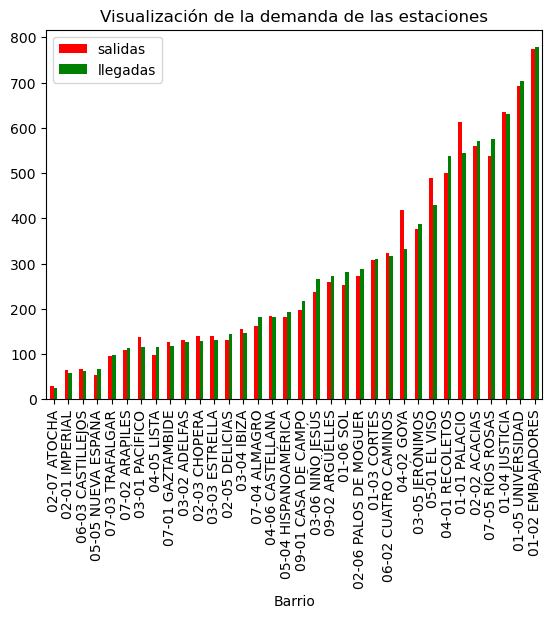

In [9]:
df_grafico.toPandas().plot.bar(
    x     = 'Barrio', 
    y     = ['salidas','llegadas'], 
    color = ['red','green'],
    title = "Visualización de la demanda de las estaciones"
)

### Estudio por años

Estudiamos el incremento de la demanda en los años

In [10]:
df_unido_salidas.limit(2).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_S
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,None,None
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,40,01-02 EMBAJADORES


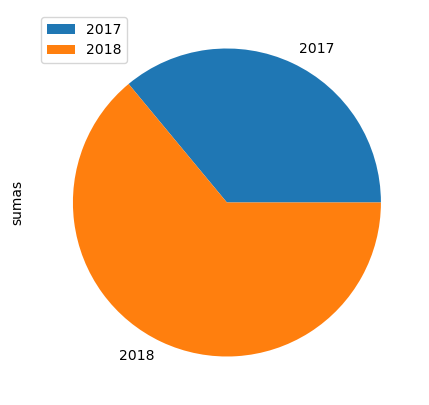

In [11]:
df_year = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(1, 4))\
            .groupBy('unplug_hourTime')\
            .count()
df_year.limit(5).toPandas()
df_grafico_tarta = pd.DataFrame({'sumas': [3602, 6398]},
                  index=['2017', '2018'])
plot = df_grafico_tarta.plot.pie(y='sumas', figsize=(5, 5))

* Aumento significativo! podemos hacer una comparacion local en barrios

### Pico máximo de uso
La máxima demanda de bicicletas en un barrio

In [12]:
df_pico = df_unido_salidas.select(*salidas)\
                        .where(sf.col("Barrio").isNotNull())\
                        .groupBy('unplug_hourTime')\
                        .count()\
                        .agg({'count': 'max'})\
                        .withColumnRenamed('max(count)', 'maximo_diario')
                        

df_pico.toPandas()
# aAhora si 

,maximo_diario
0,44


# Uso por semana en cada año

El gráfico representa la cantidad de movimientos realizados por semana en cada año.

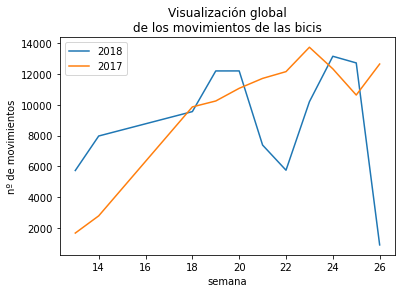

In [4]:
plot_analisys_by_year(df_new)

Nos gustaría estudiar dentro de esta tendencia general 

como se comporta BiciMad dentro de cada semana para ver si podemos encontrar otras tendenciasb

# Análisis de los movimientos globales por días de la semana
Cómo afecta el día de la semana al uso de biciMad

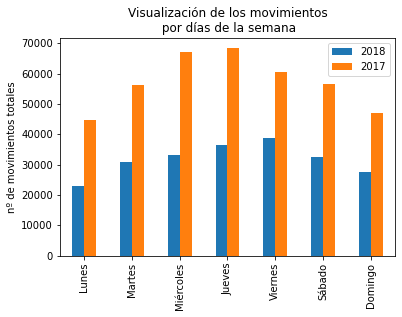

In [5]:
plot_analisys_by_day(df_new, total=True)

Mantiene la tendencia general vista antes pero además podemos ver un comportamiento creciente hasta que llega
el fin de semana, de forma cíclica

Parece que encontramos gran uniformidad en los datos, hay que tener en cuenta que este es un estudio global, por lo que nos está diciendo que durante todos los días de la semana se usan relativamente igual todas las bicis por Madrid.

Ahora bien, queremos observar en qué zonas se mueven más unos días y en qué otras zonas se mueven otros días.


# Visualización de los movimientos semanales de un barrio concreto 

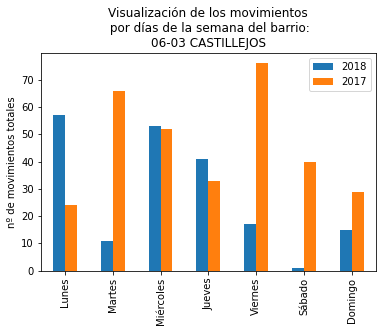

In [8]:
barrio = "06-03 CASTILLEJOS"
plot_analisys_by_day(df_new, barrio)

El pico de uso se desplaza del **viernes en 2017 a lunes en 2018**
Es notable el descenso de uso los sábados, en general el comportamiento de los usuarios ha variado mucho

Esta elección ha sido aleatoria. Vamos ahora a buscar estadísticamente barrios interesantes de los que buscar resultados.

# Estudio generalizado por barrios, para realizar un análisis global

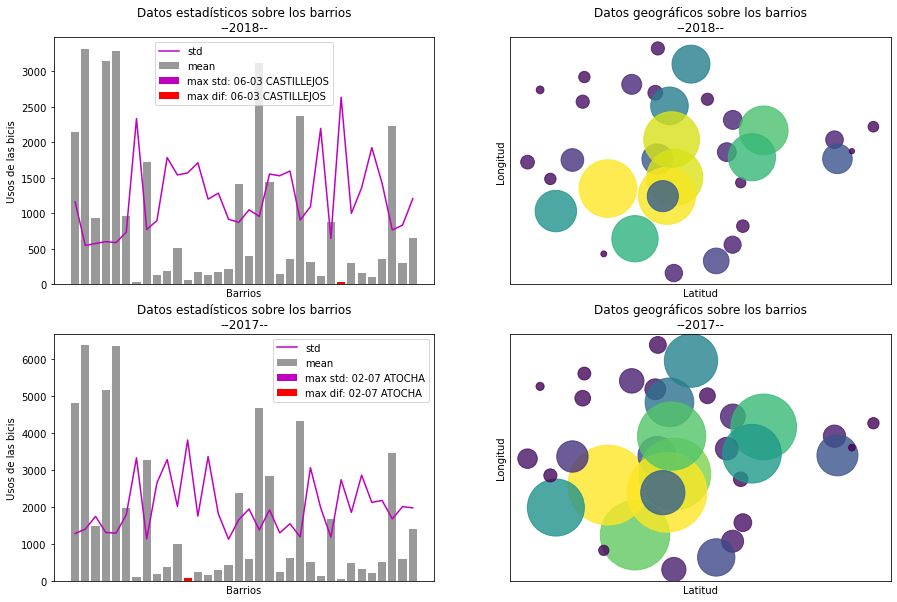

In [11]:
plot_stats(df_new)

De media, observamos mayores movimientos por el centro (los puntos amarillos) mientras que a las afueras menor uso de las bicicletas. Esto se puede deber a que disponen de más puntos donde usarlas

Parece interesante estudiar su comportamiento separando los dias de entre semana de los fines de semana

### Vamos a analizar los datos diarios de los barrios que nos han dado mayores desviaciones típicas y diferencia

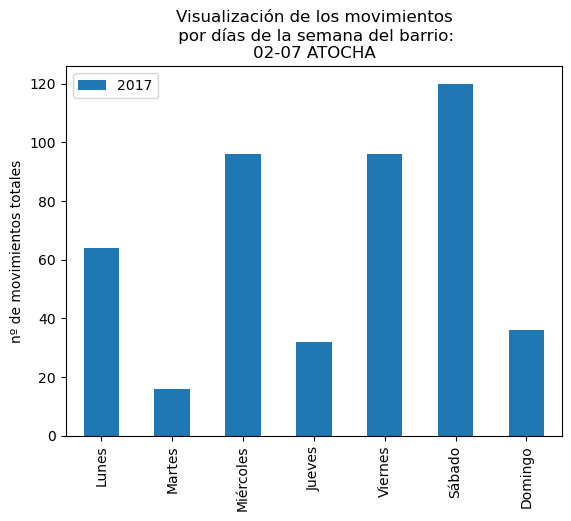

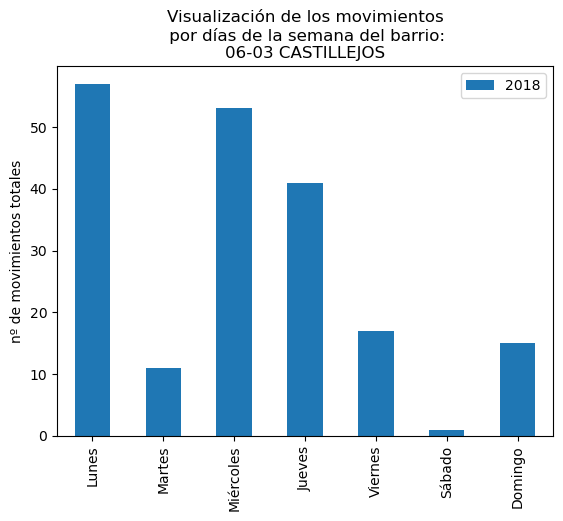

In [20]:
barrio_2017 = "02-07 ATOCHA"
barrio_2018 = "06-03 CASTILLEJOS"

plot_analisys_by_day(df_new, barrio_2017, years=["2017"])
plot_analisys_by_day(df_new, barrio_2018, years=["2018"])

 - Año 2017:
 
   - **02-07 ATOCHA**: se observa una diferencia considerable en los días viernes y sabado, es decir, durante la llegada del fin de semana es una zona bastante transitada a diferencia de los demás días de la semana.

 - Año 2018:
  
   - **06-03 CASTILLEJOS**: Se observa un claro descenso a lo largo del transcurso de la semana. Dejando los fines de semana casi inactivos en comparación con los días laborales.


Es interesante ver que los martes es un mínimo en los días laborales en dos barrios con comportamientos muy opuestos

# Estudio separado de días laborables y no laborables

 - Entre semana: Lunes, ..., Viernes
 - Fin de semana: Viernes, Sábado, Domingo

De esta forma tendremos una perspectiva más correcta de como son los ciclos semanales

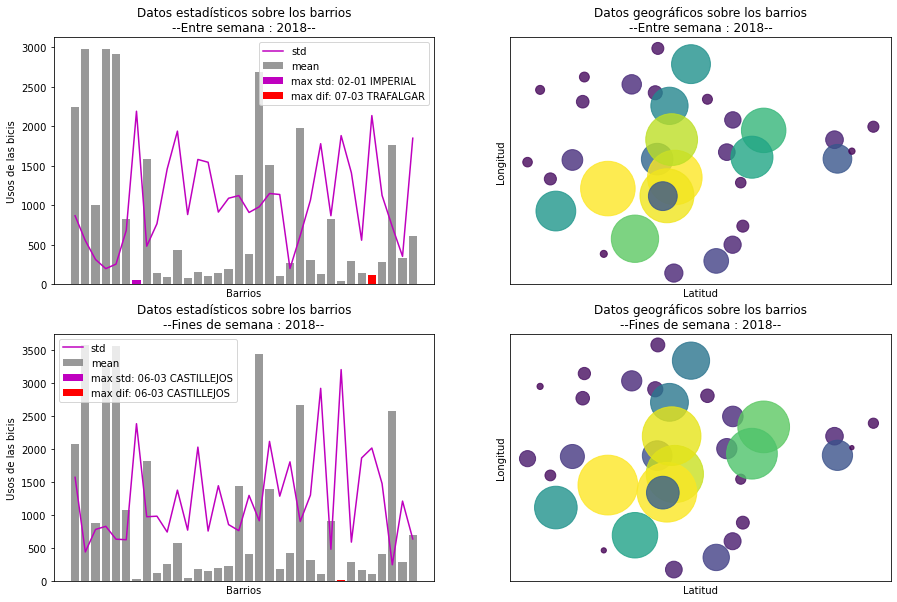

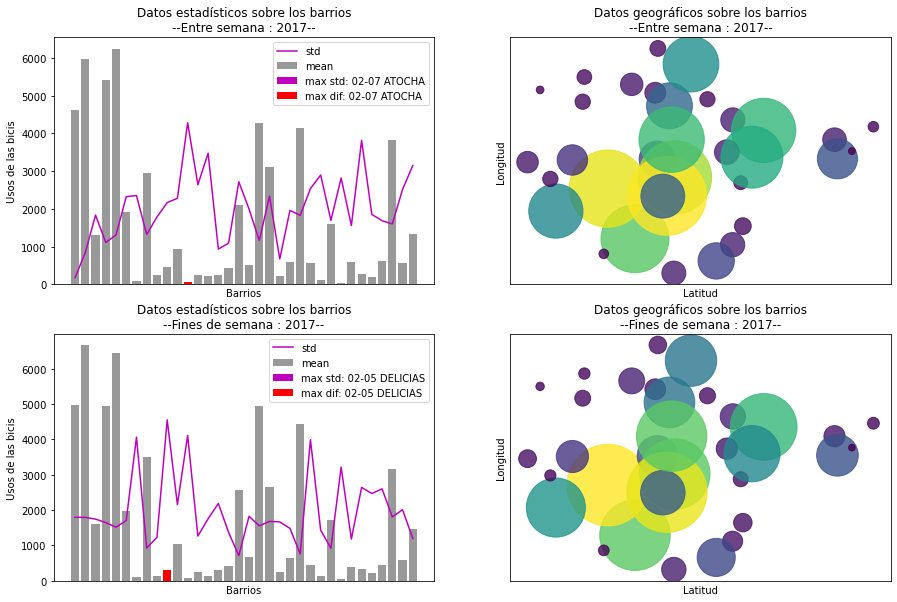

In [14]:
plot_stats_by_weekends(df_new)

Observamos que las tendencias son similares, realizamos un estudio por estaciones para ver si podemos encontrar diferencias significativas, de forma que en función de la estacón el camión que repone las bicicletas debería seguir un camino u otro.

# Estudio por estaciones del año

 - Primavera
 - Verano
 - Otoño
 - Invierno
 
Con estos datos podremos optimizar nuestras propuestas de movimientos de bicis y reposiciones con una perspectiva temporal más global. Es decir, no solo tener propuestas según el día de la semana más con un análisis más concreto temporalmente como se ha mencionó en el apartado anterior, si no que podemos adaptar pequeños detalles teniendo en cuenta las estación del año en la que nos encontramos.

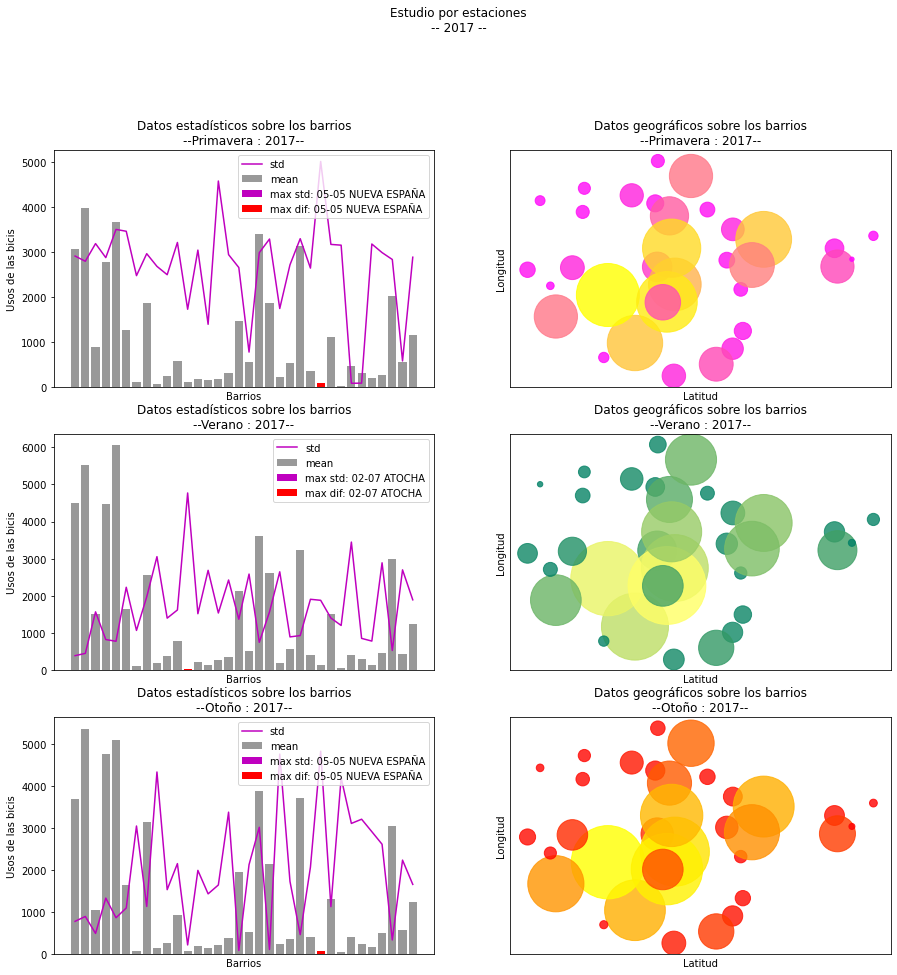

In [2]:
plot_stats_by_seasons(df_new, years=["2017"])

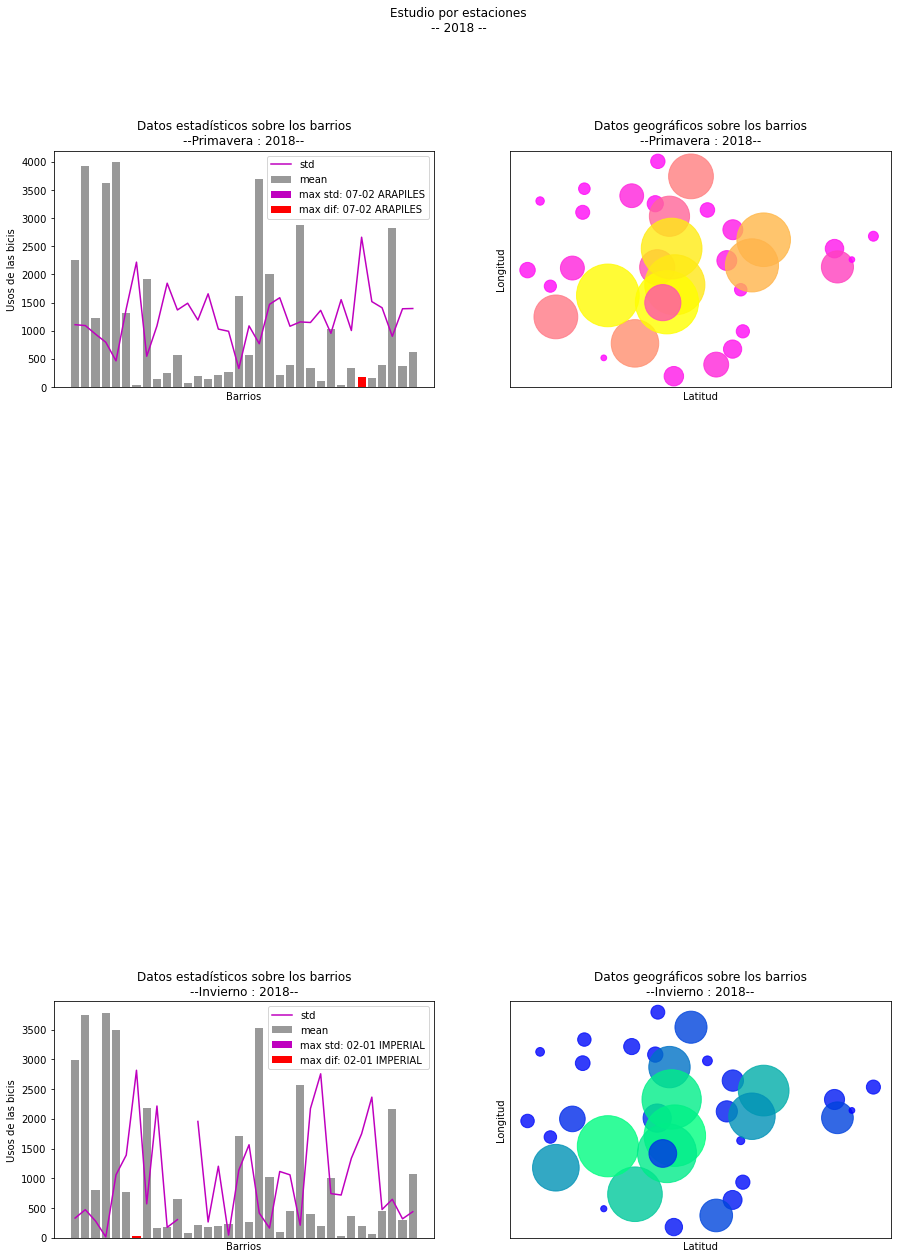

In [3]:
plot_stats_by_seasons(df_new, years=["2018"])

Comentario: Los espacios en blanco indican que no hay datos de esa estación en ese año. Lo cual en el DataFrame grande del cluster no pasará.

# Estudio de las diferencias de entradas y salidas en cada una de los barrios

Ahora vamos a centralizar el estudio en el movimiento general de los ciudadanos para tener una perspectiva global. Es decir, observar en qué zonas salen más bicis de las que entran (en el barrio) y así poder inferir un baja demanda en dicha zona. Mientras que también podemos observar en qué zonas entran más bicis de las que salen y así inferir una alta demanda en el barrio correspondiente. 

La función grafica un gráfico geográfico. Este tiene dos colores:

 - Verde: indica que en ese barrio ha habido más llegadas que salidas (el año en particular).
 - Rojo:  indica que en ese barrio ha habido más salidas que llegadas (el año en particular).
 
El tamaño del punto es directamente proporcional a dicha diferencia. Cuanto más grande, más diferencia ha habido y por lo tanto, será más significativo para el estudio. 

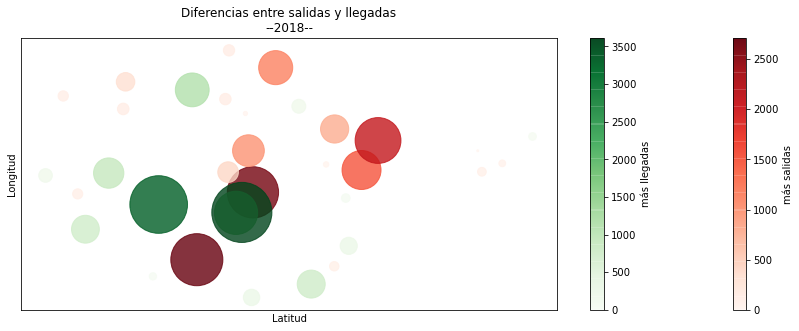

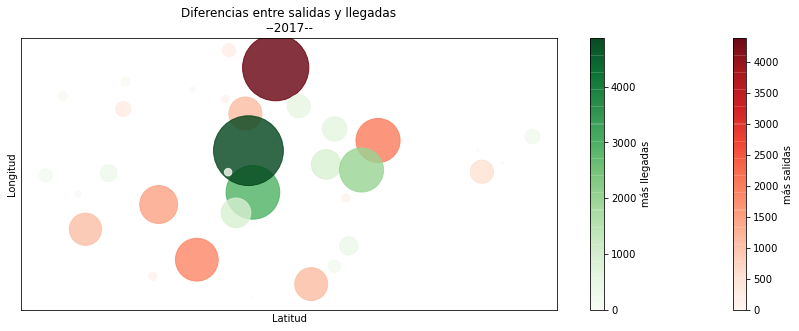

In [2]:
plot_diferencias_entrada_salida_por_barrios(df_new)

Podemos observar como en 2017 había muchas más llegadas al centro de la ciudad que de salidas. E inversamente, a las afueras nos encontramos la situación contraria, más salidas que llegadas. Esto representa dos situaciones:

 1) Los ciudadanos madrileños que se dirigen al centro de la ciudad en bici desde la afueras, superan en número los que las cogen desde el centro para irse a las afueras. 
 
 2) A las afueras hay más salidas, por lo que también es un dato interesante para mover las bicis (con el camión de la empresa bicimad) del centro a las afueras para así poder optar a más demanda. Creando un ciclo, las llevan a las afueras para que los ciudadanos las traigan hacia el centro de nuevo, así una y otra vez.

# Anexo :


Las funciones que han sido utilizadas e importadas desde *main.py* para facilidad de lectura.
No hace falta ejecutarlas, el objetivo del anexo es incluir lo que ha sido utilizado.





In [ ]:
from pyspark.sql.functions import dayofweek, dayofyear, dayofmonth, weekofyear, month, year

from pyspark.sql import functions # usaremos -> mean, stddev, max, min, col

import matplotlib.pyplot as plt
import numpy as np



def preprocess_dates(df):
    """
Separa las fechas por año, semana y día 
"""
        
    df_new = df.withColumn("dayofweek", dayofweek(df.unplug_hourTime.getItem("$date")))\
            .withColumn("month", month(df.unplug_hourTime.getItem("$date")))\
            .withColumn("weekofyear", weekofyear(df.unplug_hourTime.getItem("$date")))\
            .withColumn("year", year(df.unplug_hourTime.getItem("$date")))\
            .drop('unplug_hourTime')
    return df_new


def preprocess_ids(df, df_geo):
        
    # cambiar los ids de las estaciones por el barrio respectivo
    df_geo1  = df_geo.select("Número", "Barrio")\
                                .withColumnRenamed("Número", "idplug_station")\
                                .withColumnRenamed("Barrio", "id_llegadas")
    df_geo2 = df_geo1.withColumnRenamed("idplug_station", "idunplug_station")\
                                .withColumnRenamed("id_llegadas", "id_salidas")

    df_new = df.join(df_geo1, on="idplug_station").join(df_geo2, on="idunplug_station")\
                            .drop("idplug_station", "idunplug_station", "idplug_base", "idunplug_base")
    
    # añadir la geolocalización de los barrios
    df_geo1 = df_geo.select("Barrio", "Latitud", "Longitud")\
                                .withColumnRenamed("Barrio", "id_salidas")\
                                .withColumnRenamed("Latitud", "Latitud_salidas")\
                                .withColumnRenamed("Longitud", "Longitud_salidas")
    
    df_geo2 = df_geo1.withColumnRenamed("id_salidas", "id_llegadas")\
                                .withColumnRenamed("Latitud_salidas", "Latitud_llegadas")\
                                .withColumnRenamed("Longitud_salidas", "Longitud_llegadas")
    
    df_new = df_new.join(df_geo1, on="id_salidas").join(df_geo2, on="id_llegadas")
    
    return df_new


def preprocess(df, df_geo):
    """
resumen de los preprocesamientos
Argumentos:
    1) df = df = spark.read.json(data_path) 
    2) df_geo = spark.read.csv(data_geo_path, header=True) 
"""
    df_new = preprocess_dates(df)
    df_new = preprocess_ids(df_new, df_geo)
    return df_new


# Serán pocos valores (el nº de barrios) por lo que aunque parezca que hay mucho paso 
# a pandas y a listas, la operación no es costosa. De todas formas lo suyo es que seleccionemos nosotros
# uno manualmente
def get_random_barrio(df):
    """
Devuelve un barrio aleatorio 
"""
    return np.random.choice(df.select("id_salidas").distinct().toPandas()["id_salidas"].to_list())


def get_years(df):
    """
Devuelve los años
"""
    # Guardar una lista con todos los años disponibles del DataFrame -> no serán más de 2 / 3 valores 
    # por lo que aunque parezca que hay mucho paso a pandas y a listas, la operación no es costosa
    years = df.select("year").distinct().toPandas()["year"].to_list()
    years = list(map(str, years)) # pasarlo a tipo string
    return years



def plot_analisys_by_day(df, barrio=None, total=False, years=None): # total == True -> estudio uniendo todos los barrios
    """
#Dibuja un gráfico con los movimientos de las bicicletas en función del día de la semana a lo largo de cada año
"""  
    
    
    #Si total es true entonces hacemos un estudio de todos los barrios del Dataframe
    if not total:
        #Si no introducimos un barrio en la funcion escoge uno aleatorio
        if barrio == None:
            barrio = get_random_barrio(df)

        df_barrio = df.filter(df.id_salidas == barrio)
    else:
        df_barrio = df
    
    #Si no introducimos un año en la funcion coge todos los años
    years = get_years(df) if years == None else years
    
    df_plot = None
    
    # Agrupamos por años los datos 
    for year in years:
        df_year = df_barrio.filter(df.year == year)\
                            .groupBy("dayofweek").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="dayofweek")
    
    # Ordenar temporalmente (dayofweek) y luego hacemos un plot de todos los años
    ss = f" del barrio:\n{barrio}" if not total else ""
    df_plot.orderBy("dayofweek").toPandas().plot.bar(
            x = "dayofweek", 
            y = years,
            title = f"Visualización de los movimientos\n por días de la semana{ss}",
            ylabel="nº de movimientos totales",
            xlabel=""
    ).set_xticklabels(["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
    


def plot_analisys_by_year(df, years=None):
    """
Dibuja un gráfico con el crecimiento de los movimientos de las bicicletas a lo largo de los años
"""
    
    years = get_years(df) if years == None else years
    
    df_plot = None
    
    # hacer una columna para cada año del conteo de la columna que queramos medir
    for year in years:
        df_year = df.filter(df.year == year)\
                            .groupBy("weekofyear").count()\
                                .withColumnRenamed("count", year)
        if df_plot == None:
            df_plot = df_year
        else:
            df_plot = df_plot.join(df_year, on="weekofyear")
    
    # ordenar temporalmente (weekofyear) y luego hacer un plot de todos los años
    df_plot.orderBy("weekofyear").toPandas().plot(
            x = "weekofyear", 
            y = years,
            title = "Visualización global\nde los movimientos de las bicis",
            xlabel="semana",
            ylabel="nº de movimientos"
    )



def plot_stats(df, years=None):
    """
Dibuja un gráfico con la densidad de los movimientos de las bicicletas en las distintas zonas y 
 un gráfico con resultados estadísticos relevantes como la media, el máximo y mínimo .
"""
    
    years = get_years(df) if years == None else years
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    # nº de filas = len(years)
    f = len(years)
    
    # nº de columnas = 2 -> una para las gráficas y otro con geolocalizaciones y algún atributo
    c = 2
    
    # crear plot
    fig = plt.figure(figsize=(15,5*f))
    
    for i, year in enumerate(years):
        
        df2 = df.filter(df.year == year).groupBy('id_salidas', 'dayofweek').count().orderBy('id_salidas')

        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats = df2.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats["std"] = df_stats["std"] / df_stats["mean"] * df_stats["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats["dif"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]
        
        maximo_std = df_stats[df_stats["std"] == df_stats["std"].max()]
        maximo_dif = df_stats[df_stats["dif"] == df_stats["dif"].max()]

        # PLOT IZQUIERDO
        # --------------
        # Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        
        ax = fig.add_subplot(f, c, 2*i + 1)

        n = df_stats.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats["std"].values, "m-", label="std")
        ax.bar(x, df_stats["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std.index[0], maximo_std["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std["id_salidas"].values[0]))
        ax.bar(maximo_dif.index[0], maximo_dif["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--{year}--")

        
        # PLOT DERECHO
        # ------------
        # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
        #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
        #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

        ax = fig.add_subplot(f, c, 2*i + 2)
        
        
        df_stats.Latitud_salidas = df_stats.Latitud_salidas.astype("float64")
        df_stats.Longitud_salidas = df_stats.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats["Latitud_salidas"],
            y = df_stats["Longitud_salidas"],
            c = df_stats["mean"],
            s = df_stats["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--{year}--")

        
    
    plt.show()





def plot_stats_by_weekends(df, years=None):
    """
Dibuja un gráfico con la densidad de los movimientos de las bicicletas en las distintas zonas y 
un gráfico con resultados estadísticos relevantes como la media, el máximo y mínimo .
Esto lo hace diferenciando entre fin de semana (V, S, D) y entre semana (L, M, X, J)
"""
    
    
    years = get_years(df) if years == None else years
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    
    for year in years:
        
        # crear plot
        fig = plt.figure(figsize=(15,5*2))
        f, c = 2, 2
    
        
        df2 = df.filter(df.year == year)\
                    .groupBy("id_salidas", "dayofweek").count()\
                    .orderBy("id_salidas")
        
        # si es fin de semana o no
        df_si = df2.filter(df2.dayofweek >= 4)
        df_no = df2.filter(df2.dayofweek <  4)


        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats_si = df_si.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        
        df_stats_no = df_no.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats_si["std"] = df_stats_si["std"] / df_stats_si["mean"] * df_stats_si["mean"].max()
        df_stats_no["std"] = df_stats_no["std"] / df_stats_no["mean"] * df_stats_no["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats_si["dif"] = (df_stats_si["max"] - df_stats_si["min"]) / df_stats_si["mean"]
        df_stats_no["dif"] = (df_stats_no["max"] - df_stats_no["min"]) / df_stats_no["mean"]
        
        # maximos
        maximo_std_si = df_stats_si[df_stats_si["std"] == df_stats_si["std"].max()]
        maximo_dif_si = df_stats_si[df_stats_si["dif"] == df_stats_si["dif"].max()]
        
        maximo_std_no = df_stats_no[df_stats_no["std"] == df_stats_no["std"].max()]
        maximo_dif_no = df_stats_no[df_stats_no["dif"] == df_stats_no["dif"].max()]

        # PLOT IZQUIERDO
        # --------------
        # Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        
        # --------------- ENTRE SEMANA ---------------
        
        ax = fig.add_subplot(f, c, 1)

        n = df_stats_no.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats_no["std"].values, "m-", label="std")
        ax.bar(x, df_stats_no["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std_no.index[0], maximo_std_no["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std_no["id_salidas"].values[0]))
        ax.bar(maximo_dif_no.index[0], maximo_dif_no["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif_no["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--Entre semana : {year}--")
        
        # --------------- FIN DE SEMANA ---------------
        
        ax = fig.add_subplot(f, c, 3)

        n = df_stats_si.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats_si["std"].values, "m-", label="std")
        ax.bar(x, df_stats_si["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std_si.index[0], maximo_std_si["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std_si["id_salidas"].values[0]))
        ax.bar(maximo_dif_si.index[0], maximo_dif_si["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif_si["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--Fines de semana : {year}--")

        
        # PLOT DERECHO
        # ------------
        # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
        #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
        #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

        # --------------- ENTRE SEMANA ---------------

        ax = fig.add_subplot(f, c, 2)
        
        df_stats_no.Latitud_salidas = df_stats_no.Latitud_salidas.astype("float64")
        df_stats_no.Longitud_salidas = df_stats_no.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats_no["Latitud_salidas"],
            y = df_stats_no["Longitud_salidas"],
            c = df_stats_no["mean"],
            s = df_stats_no["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--Entre semana : {year}--")

        # --------------- FIN DE SEMANA ---------------

        ax = fig.add_subplot(f, c, 4)
        
        df_stats_si.Latitud_salidas = df_stats_si.Latitud_salidas.astype("float64")
        df_stats_si.Longitud_salidas = df_stats_si.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats_si["Latitud_salidas"],
            y = df_stats_si["Longitud_salidas"],
            c = df_stats_si["mean"],
            s = df_stats_si["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--Fines de semana : {year}--")
    
        plt.show()





def plot_stats_by_seasons(df, years=None):
    """
Dibuja un gráfico con la densidad de los movimientos de las bicicletas en las distintas zonas y 
un gráfico con resultados estadísticos relevantes como la media, el máximo y mínimo .
Esto lo hace diferenciando entre estaciones: Primavera, Verano, Otoño, Invierno
"""
    
    years = get_years(df) if years == None else years
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    
    for year in years:
        
        # crear plot
        f, c = 4, 2
        fig = plt.figure(figsize=(15,5*f))
        fig.suptitle(f'Estudio por estaciones\n-- {year} --')
    
        df2 = df.filter(df.year == year)\
                    .groupBy("id_salidas", "month").count()\
                    .orderBy("id_salidas")
        
        # separar en estaciones
        names = ["Primavera", "Verano", "Otoño", "Invierno"]
        cmaps = ["spring", "summer", "autumn", "winter"] # tipos de mapas de colores
        df_seasons = [
                df2.filter(df2.month >= 3).filter(df2.month <= 6), 
                df2.filter(df2.month >= 7).filter(df2.month <= 9), 
                df2.filter(df2.month >= 10).filter(df2.month <= 12), 
                df2.filter(df2.month >= 1).filter(df2.month <= 2)
        ] 

        for i in range(4):

            # recuperar info
            df_season = df_seasons[i]
            name = names[i]
            cmap = cmaps[i]

            # Añadir la desviación típica y la media de cada una de las estaciones
            df_stats = df_season.groupBy("id_salidas").agg(
                    functions.mean("count").alias("mean"), 
                    functions.stddev("count").alias('std'),
                    functions.min("count").alias('min'),
                    functions.max("count").alias('max'),
            ).join(df_geo, "id_salidas", "left").toPandas()
            
            n = len(df_stats)
            
            if n == 0:
                # no tenemos datos de esta estación
                continue

            # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
            # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
            # gráfica (los valores reales serán proporcionales a los resultados)
            df_stats["std"] = df_stats["std"] / df_stats["mean"] * df_stats["mean"].max()
            
            # Columna con las diferencias (relativas) máximo - mínimo
            df_stats["dif"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]
            
            # maximos
            maximo_std = df_stats[df_stats["std"] == df_stats["std"].max()]
            maximo_dif = df_stats[df_stats["dif"] == df_stats["dif"].max()]
            
            
            # PLOT IZQUIERDO
            # --------------
            # Tendremos:
            #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
            #  - LinePlot de las std (relativa) en rojo
            #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
                
            ax = fig.add_subplot(f, c, 2*i + 1)

            x = range(n)
            
            ax.plot(x, df_stats["std"].values, "m-", label="std")
            ax.bar(x, df_stats["mean"].values, color="grey", alpha=0.8, label="mean")
            ax.bar(maximo_std.index, maximo_std["mean"].values, 
                    color="m", label="max std: " + str(maximo_std["id_salidas"].values[0]))
            ax.bar(maximo_dif.index, maximo_dif["mean"].values, 
                        color="red", label="max dif: " + str(maximo_dif["id_salidas"].values[0]))
            ax.legend()
            ax.set_xlabel("Barrios")
            ax.set_ylabel("Usos de las bicis")
            ax.set_xticks([])
            ax.set_title(f"Datos estadísticos sobre los barrios\n--{name} : {year}--")
            
            
            # PLOT DERECHO
            # ------------
            # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
            #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
            #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

            ax = fig.add_subplot(f, c, 2*i + 2)
            
            df_stats.Latitud_salidas = df_stats.Latitud_salidas.astype("float64")
            df_stats.Longitud_salidas = df_stats.Longitud_salidas.astype("float64")
            
            cmap = plt.cm.get_cmap(cmaps[i])     # mapa de colores
            norm = plt.Normalize(df_stats["mean"].min(), df_stats["mean"].max()) # Normalizar los valores para el mapa de colores
            
            ax.scatter(
                x = df_stats["Latitud_salidas"],
                y = df_stats["Longitud_salidas"],
                s = df_stats["mean"],
                c = df_stats["mean"],
                cmap = cmap,
                norm = norm,
                alpha = 0.8
            )
            ax.set_xlabel("Latitud")
            ax.set_ylabel("Longitud")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Datos geográficos sobre los barrios\n--{name} : {year}--")

            # --------------

        plt.show()

        



def plot_diferencias_entrada_salida_por_barrios(df, years=None):
    """
Dibuja un gráfico de puntos de los barrios y pinta en verde los barrios en los que entran más bicis y en rojo los que salen mas bicis
El tamaño de los puntos va en funcón de la diferencia entre entradas y salidas de las bicicletas.
"""

        
    years = get_years(df) if years == None else years
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])\
                                .withColumnRenamed("id_salidas", "id")\
                                .withColumnRenamed("Latitud_salidas", "Latitud")\
                                .withColumnRenamed("Longitud_salidas", "Longitud")\
    
    for year in years:
        
        # sacar los datos de llegadas y salidas
        df_salidas = df.filter(df.year == year).groupBy('id_salidas').count()\
                                        .withColumnRenamed("id_salidas", "id")\
                                        .withColumnRenamed("count", "n_salidas")\
                                        .orderBy("id")
        df_llegadas = df.filter(df.year == year).groupBy('id_llegadas').count()\
                                        .withColumnRenamed("id_llegadas", "id")\
                                        .withColumnRenamed("count", "n_llegadas")\
                                        .orderBy("id")
        
        # unimos salidas y llegadas y añadimos la columna "diferencia" (resta de ambas)
        df_total = df_salidas.join(df_llegadas, "id").join(df_geo, "id", "left")
        df_total = df_total.withColumn("diferencia", 
                            functions.col("n_salidas") - functions.col("n_llegadas"))\
                                                                                .toPandas()
        
        # creamos do scolumnas separadas para ver dónde hay más salidas que llegadas y viceversa
        df_total["mas_salidas"] = df_total["diferencia"].apply(lambda x : max(x, 0))
        df_total["mas_llegadas"] = df_total["diferencia"].apply(lambda x : max(-x, 0))
        
        # cambiamos los tipos de datos para que se puedan interpretar
        df_total.Latitud = df_total.Latitud.astype("float64")
        df_total.Longitud = df_total.Longitud.astype("float64")
        
        fig = plt.figure(figsize=(15,5))
        
        ax = fig.add_subplot(111)
        
        # PLOT : más salidas
        
        cmap = plt.cm.get_cmap("Reds")     # mapa de colores
        norm = plt.Normalize(df_total["mas_salidas"].min(), df_total["mas_salidas"].max()) # Normalizar los valores para el mapa de colores
            
        scatter = ax.scatter(
            x = df_total["Latitud"],
            y = df_total["Longitud"],
            s = df_total["mas_salidas"],
            c = df_total["mas_salidas"],
            cmap = cmap,
            norm = norm,
            alpha = 0.8,
            label = "más salidas"
        )
        
        colorbar = fig.colorbar(scatter)
        colorbar.set_label("más salidas")
        
        # PLOT : más llegadas
   
        cmap = plt.cm.get_cmap("Greens")     # mapa de colores
        norm = plt.Normalize(df_total["mas_llegadas"].min(), df_total["mas_llegadas"].max()) # Normalizar los valores para el mapa de colores
            
        scatter = ax.scatter(
            x = df_total["Latitud"],
            y = df_total["Longitud"],
            s = df_total["mas_llegadas"],
            c = df_total["mas_llegadas"],
            cmap = cmap,
            norm = norm,
            alpha = 0.8,
            label = "más llegadas"
        )
        
        colorbar = fig.colorbar(scatter)
        colorbar.set_label("más llegadas")
        
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Diferencias entre salidas y llegadas\n--{year}--")


        plt.show()

        
        

        